In [160]:
# Data Management & Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import geopandas as gpd
import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

# Utils
from datetime import datetime, timedelta
import ipywidgets as widgets
import random
import warnings
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
from time import sleep
%matplotlib inline
sns.set_style('white')
sns.set_color_codes()
plt.style.use('default')  # sub 'dark_background'
warnings.filterwarnings("ignore")


# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [161]:
patients_df = pd.read_csv('./uc_past_patients.csv', index_col='pt_id')
patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code
pt_id,,,,,,,,,,,,
1000004,Christopher Clark Jr.,2021-11-01,0,denver,rash/allergy,5,2021-05-01,Saturday,10:46:44,11:34:44,1,0.0
1000014,Janet Rowe,1969-05-13,52,denver,vaccination,3,2021-05-01,Saturday,10:53:58,12:04:58,2,5.0
1000016,Anthony Johnson,1990-07-06,31,denver,cough,4,2021-05-01,Saturday,11:02:39,12:08:39,3,4.0
1000007,Debra Huerta,1963-10-30,58,denver,cold/flu/fever,4,2021-05-01,Saturday,11:09:27,12:29:27,4,4.0
1000010,Paul Hammond,1974-07-10,47,denver,drug-test,3,2021-05-01,Saturday,11:29:30,12:30:30,3,4.5


In [175]:
patients_df.visit_location.unique()

array(['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood'],
      dtype=object)

In [192]:
def make_predictions(df):
    model_df = df[['visit_date', 'visit_day', 'rolling_code', 'rolling_ct']].copy()
    model_df = model_df.groupby(['visit_date', 'visit_day']).max()[['rolling_code', 'rolling_ct']].reset_index(drop=False) \
    .rename(columns={'rolling_ct':'peak_ct', 'visit_date':'visit_month', 'rolling_code':'peak_avg_code'})

    # display(model_df)

    model_df['visit_month'] = model_df.visit_month.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
    model_df.peak_avg_code.hist()
    # Scaler
    scaler = MinMaxScaler()
    model_df['peak_avg_code_s'] = scaler.fit_transform(model_df[['peak_avg_code']])
    model_df = model_df[['visit_month', 'visit_day', 'peak_avg_code_s', 'peak_ct']]
    # Change dtype
    model_df['visit_month'] = model_df.visit_month.astype('category')
    # Make dummies
    dummies = pd.get_dummies(model_df[['visit_month', 'visit_day']])
    # Set up for partitioning
    X = pd.concat([dummies, model_df['peak_avg_code_s'].copy()], axis=1)
    y = model_df.peak_ct.copy()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    rf_train_pred = rf.predict(X_train)
    rf_test_pred = rf.predict(X_test)

    rf_train_mse = mean_squared_error(y_train, rf_train_pred)
    # print('train:', np.sqrt(rf_train_mse))

    rf_test_mse = mean_squared_error(y_test, rf_test_pred)
    rmse = np.sqrt(rf_test_mse)

    df = X_test.copy()
    df['pred'] = rf_test_pred
    df['actual'] = y_test
    
    return (df, ('rmse', rmse))



In [193]:
denver_df = patients_df[patients_df.visit_location == 'denver']
edgewater_df = patients_df[patients_df.visit_location == 'edgewater']
wheatridge_df = patients_df[patients_df.visit_location == 'wheatridge']
rino_df = patients_df[patients_df.visit_location == 'rino']
lakewood_df = patients_df[patients_df.visit_location == 'lakewood']


In [210]:
t = patients_df[patients_df.visit_location=='lakewood'].groupby(['visit_location', 'visit_date', 'visit_day']).max().reset_index(drop=False)
t[ (t.visit_date.str.contains('2022-03')) & (t.visit_day == 'Sunday')]['rolling_ct'].mean()

11.0

('rmse', 2.357519957017755)


,visit_month_1,visit_month_2,visit_month_3,visit_month_4,visit_month_5,visit_month_6,visit_month_7,visit_month_8,visit_month_9,visit_month_10,...,visit_day_Friday,visit_day_Monday,visit_day_Saturday,visit_day_Sunday,visit_day_Thursday,visit_day_Tuesday,visit_day_Wednesday,peak_avg_code_s,pred,actual
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.0,11.004762,12
33,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1.0,10.986667,10
15,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1.0,9.691952,15
309,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1.0,12.608286,7
57,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1.0,10.913857,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1.0,13.111167,10
229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.0,11.786500,10
360,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1.0,9.419238,10
209,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1.0,11.707008,11


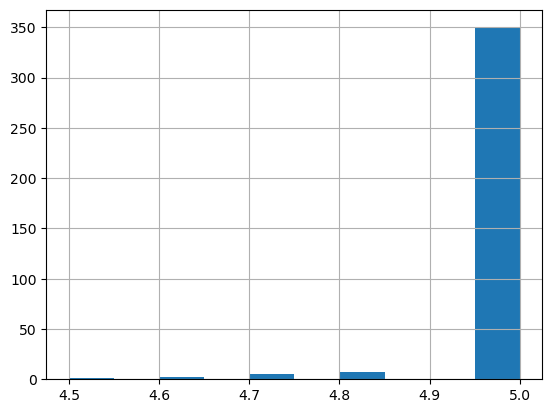

In [194]:
df, rmse = make_predictions(lakewood_df)
print(rmse)
df

,visit_location,visit_month,visit_day,peak_avg_code,peak_ct
0,denver,2021-05-01,Saturday,5.0,14
1,denver,2021-05-02,Sunday,5.0,13
2,denver,2021-05-03,Monday,5.0,12
3,denver,2021-05-04,Tuesday,5.0,13
4,denver,2021-05-05,Wednesday,5.0,11
...,...,...,...,...,...
1820,wheatridge,2022-04-26,Tuesday,4.8,10
1821,wheatridge,2022-04-27,Wednesday,5.0,13
1822,wheatridge,2022-04-28,Thursday,5.0,13
1823,wheatridge,2022-04-29,Friday,5.0,10


<AxesSubplot:>

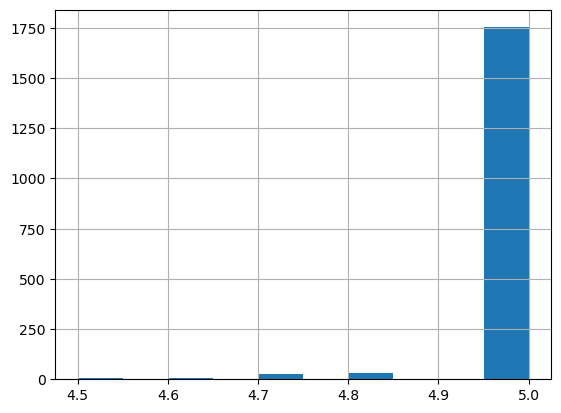

In [162]:
model_df = patients_df[['visit_location', 'visit_date', 'visit_day', 'rolling_code', 'rolling_ct']].copy()
model_df = model_df.groupby(['visit_location', 'visit_date', 'visit_day']).max()[['rolling_code', 'rolling_ct']].reset_index(drop=False) \
    .rename(columns={'rolling_ct':'peak_ct', 'visit_date':'visit_month', 'rolling_code':'peak_avg_code'})

display(model_df)

model_df['visit_month'] = model_df.visit_month.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
model_df.peak_avg_code.hist()

In [163]:
scaler = MinMaxScaler()
model_df['peak_avg_code_s'] = scaler.fit_transform(model_df[['peak_avg_code']])
model_df = model_df[['visit_location', 'visit_month', 'visit_day', 'peak_avg_code_s', 'peak_ct']]
model_df

,visit_location,visit_month,visit_day,peak_avg_code_s,peak_ct
0,denver,5,Saturday,1.0,14
1,denver,5,Sunday,1.0,13
2,denver,5,Monday,1.0,12
3,denver,5,Tuesday,1.0,13
4,denver,5,Wednesday,1.0,11
...,...,...,...,...,...
1820,wheatridge,4,Tuesday,0.6,10
1821,wheatridge,4,Wednesday,1.0,13
1822,wheatridge,4,Thursday,1.0,13
1823,wheatridge,4,Friday,1.0,10


In [164]:
model_df.dtypes

visit_location      object
visit_month          int64
visit_day           object
peak_avg_code_s    float64
peak_ct              int64
dtype: object

In [165]:
model_df['visit_month'] = model_df.visit_month.astype('category')

In [166]:
dummies = pd.get_dummies(model_df[['visit_location', 'visit_month', 'visit_day']])
dummies

,visit_location_denver,visit_location_edgewater,visit_location_lakewood,visit_location_rino,visit_location_wheatridge,visit_month_1,visit_month_2,visit_month_3,visit_month_4,visit_month_5,...,visit_month_10,visit_month_11,visit_month_12,visit_day_Friday,visit_day_Monday,visit_day_Saturday,visit_day_Sunday,visit_day_Thursday,visit_day_Tuesday,visit_day_Wednesday
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1821,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1822,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1823,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [167]:
# Set up for partitioning
X = pd.concat([dummies, model_df['peak_avg_code_s'].copy()], axis=1)
y = model_df.peak_ct.copy()

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [169]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_train_pred = lr.predict(X_train)
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
np.sqrt(lr_train_mse)

2.1198457546233582

In [170]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

rf_train_mse = mean_squared_error(y_train, rf_train_pred)
print('train:', np.sqrt(rf_train_mse))

rf_test_mse = mean_squared_error(y_test, rf_test_pred)
np.sqrt(rf_test_mse)

train: 1.740810053256728


2.4565926467597423

In [171]:
X_test

,visit_location_denver,visit_location_edgewater,visit_location_lakewood,visit_location_rino,visit_location_wheatridge,visit_month_1,visit_month_2,visit_month_3,visit_month_4,visit_month_5,...,visit_month_11,visit_month_12,visit_day_Friday,visit_day_Monday,visit_day_Saturday,visit_day_Sunday,visit_day_Thursday,visit_day_Tuesday,visit_day_Wednesday,peak_avg_code_s
555,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1.0
1744,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
297,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
733,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1.0
910,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1.0
1214,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.0
1029,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
1468,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1.0


In [172]:
 pd.DataFrame(rf_test_pred)

,0
0,7.687810
1,11.078333
2,14.557048
3,9.633246
4,10.383250
...,...
543,11.797091
544,12.964167
545,10.584429
546,8.403857


In [174]:
test = X_test.copy()
test['pred'] = rf_test_pred
test

,visit_location_denver,visit_location_edgewater,visit_location_lakewood,visit_location_rino,visit_location_wheatridge,visit_month_1,visit_month_2,visit_month_3,visit_month_4,visit_month_5,...,visit_month_12,visit_day_Friday,visit_day_Monday,visit_day_Saturday,visit_day_Sunday,visit_day_Thursday,visit_day_Tuesday,visit_day_Wednesday,peak_avg_code_s,pred
555,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1.0,7.687810
1744,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1.0,11.078333
297,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1.0,14.557048
733,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1.0,9.633246
910,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.6,10.383250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.0,11.797091
1214,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.0,12.964167
1029,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.0,10.584429
1468,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1.0,8.403857
